In [1]:
import pandas as pd

df = pd.read_csv("hf://datasets/bitext/Bitext-customer-support-llm-chatbot-training-dataset/Bitext_Sample_Customer_Support_Training_Dataset_27K_responses-v11.csv")

c:\Users\vivek gupta\Desktop\Customer Support Chatbot\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df.head()

,flags,instruction,category,intent,response
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...


In [3]:
# Check dataset info
print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())
print("\nNumber of unique intents:", df['intent'].nunique())
print("\nIntent distribution:")
print(df['intent'].value_counts().head(10))

Dataset shape: (26872, 5)

Column names: ['flags', 'instruction', 'category', 'intent', 'response']

Data types:
flags          object
instruction    object
category       object
intent         object
response       object
dtype: object

Missing values:
flags          0
instruction    0
category       0
intent         0
response       0
dtype: int64

Number of unique intents: 27

Intent distribution:
intent
contact_customer_service    1000
complaint                   1000
check_invoice               1000
switch_account              1000
edit_account                1000
contact_human_agent          999
check_payment_methods        999
delivery_period              999
newsletter_subscription      999
get_invoice                  999
Name: count, dtype: int64


## Data Cleaning

In [4]:
import re

# Create a copy for cleaning
df_clean = df.copy()

# Remove placeholders like {{Order Number}}, {{Invoice Number}}, etc.
df_clean['instruction_clean'] = df_clean['instruction'].apply(
    lambda x: re.sub(r'\{\{.*?\}\}', '', x)
)

# Convert to lowercase
df_clean['instruction_clean'] = df_clean['instruction_clean'].str.lower()

# Remove extra whitespaces
df_clean['instruction_clean'] = df_clean['instruction_clean'].str.strip() # Remove leading and trailing whitespace
df_clean['instruction_clean'] = df_clean['instruction_clean'].apply(
    lambda x: re.sub(r'\s+', ' ', x)
)

# Remove any rows with empty instructions after cleaning
df_clean = df_clean[df_clean['instruction_clean'].str.len() > 0]

print("Dataset shape after cleaning:", df_clean.shape)
print("\nSample cleaned instructions:")
print(df_clean[['instruction', 'instruction_clean', 'intent']].head(10))

Dataset shape after cleaning: (26872, 6)

Sample cleaned instructions:
                                         instruction  \
0   question about cancelling order {{Order Number}}   
1  i have a question about cancelling oorder {{Or...   
2    i need help cancelling puchase {{Order Number}}   
3         I need to cancel purchase {{Order Number}}   
4  I cannot afford this order, cancel purchase {{...   
5     can you help me cancel order {{Order Number}}?   
6  I can no longer afford order {{Order Number}},...   
7    I am trying to cancel purchase {{Order Number}}   
8     I have got to cancel purchase {{Order Number}}   
9    i need help canceling purchase {{Order Number}}   

                             instruction_clean        intent  
0              question about cancelling order  cancel_order  
1    i have a question about cancelling oorder  cancel_order  
2               i need help cancelling puchase  cancel_order  
3                    i need to cancel purchase  cancel_order

## Intent Classification Model using NLP + Logistic Regression

In [5]:
# Install required packages if not already installed
import subprocess
import sys

packages = ['scikit-learn', 'nltk']
for package in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])

In [6]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK resources
nltk.download('stopwords', quiet=True) # Download stopwords
nltk.download('punkt', quiet=True) # Download tokenizer models
nltk.download('punkt_tab', quiet=True) # Download tokenizer models for tab-separated data

print("Libraries imported successfully!")

Libraries imported successfully!


In [7]:
# Prepare features and labels
X = df_clean['instruction_clean']
y = df_clean['intent']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())

Training set size: 21497
Testing set size: 5375

Class distribution in training set:
intent
check_invoice               800
contact_customer_service    800
switch_account              800
edit_account                800
complaint                   800
delivery_period             799
payment_issue               799
contact_human_agent         799
get_invoice                 799
registration_problems       799
check_payment_methods       799
newsletter_subscription     799
create_account              798
review                      798
place_order                 798
cancel_order                798
track_refund                798
check_refund_policy         798
get_refund                  798
set_up_shipping_address     798
change_order                798
delivery_options            796
track_order                 796
recover_password            796
delete_account              796
change_shipping_address     778
check_cancellation_fee      760
Name: count, dtype: int64


In [8]:
# Create TF-IDF Vectorizer
# TF-IDF converts text to numerical features
# - removes english stopwords (common words like 'the', 'is', 'and')
# - uses unigrams and bigrams (1 and 2 word phrases)
# - limits to top 5000 features
# why these parameters? To reduce dimensionality and focus on most important words/phrases, while capturing more context with bigrams and removing noise with stopwords.

# why tfidf?
# TF-IDF (Term Frequency-Inverse Document Frequency) is a common technique for converting text 
# into numerical features that can be used by machine learning models. It helps to highlight 
# important words in the documents while down-weighting common words that appear in many documents.
# This makes it a good choice for text classification tasks like intent classification, as it 
# can help the model focus on the most relevant features for distinguishing between different intents.

# why we are not use other embedding techniques like word2vec or BERT?
# While word2vec and BERT are powerful embedding techniques that capture semantic meaning, they
# can be more complex and computationally expensive to implement, especially for a simple intent classification task
# if we use this how it is expensive? It requires more computational resources and time to train 
# and fine-tune these models, especially if we have a large dataset. Additionally, for a task 
# like intent classification, which may not require deep contextual understanding, TF-IDF can 
# often provide sufficient performance with much less complexity.
# why it is simple TFIDF is a simpler technique that can be implemented quickly and easily, and it often performs well for
# tasks like intent classification where the goal is to identify key words and phrases that 
# indicate the intent.

# for which type of task bert or word2vec is better? BERT and word2vec are better suited for tasks 
# that require a deeper understanding of context and semantics, such as sentiment analysis, 
# named entity recognition, or any task where the meaning of words can change based on their context. For example, in sentiment analysis, BERT can capture the nuances of language that indicate positive or negative sentiment, while TF-IDF might struggle to differentiate between words that are commonly used in both positive and negative contexts.
# if i use word2vec or bert how it will be better? Using word2vec or BERT can provide better 
# performance for tasks that require understanding the context and semantics of the text. 
# Word2vec captures semantic relationships between words by learning word embeddings based on 
# their co-occurrence in the training data, while BERT uses a transformer architecture to 
# capture bidirectional context, allowing it to understand the meaning of words in relation to 
# the entire sentence. This can lead to improved accuracy in tasks like intent classification, especially when dealing with complex sentences or when the same words can have different meanings based on context.

# if i use bert in this then it can improve the performance of the intent classification model 
# by providing richer contextual embeddings that capture the nuances of language, which can help 
# the model better understand the intent behind user instructions, especially in cases where the 
# same words can have different meanings based on context. However, it may also require more 
# computational resources and time to train and fine-tune the BERT model compared to using TF-IDF.

# why we are not using word2vec or bert? We are not using word2vec or BERT in this case because 
# our primary goal is to build a simple and efficient intent classification model. TF-IDF is a 
# straightforward technique that can provide good performance for this task without the need for 
# complex models like word2vec or BERT, which may require more computational resources and time 
# to train. Additionally, for a task like intent classification, where the focus is on identifying
# key words and phrases that indicate the intent, TF-IDF can often be sufficient to achieve good 
# results without the added complexity of deep learning models.
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000, # Limit to top 5000 features why? To reduce dimensionality and focus on most important words/phrases
    ngram_range=(1, 2), # Use unigrams and bigrams to capture more context
    stop_words='english', # Remove common English stopwords that don't add much meaning
    min_df=2, # Ignore words that appear in less than 2 documents
    max_df=0.9 # Ignore words that appear in more than 90% of documents (too common)
)

# Transform training and testing data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF Vectorization completed!")
print(f"Training data shape: {X_train_tfidf.shape}")
print(f"Testing data shape: {X_test_tfidf.shape}")
print(f"Number of features: {len(tfidf_vectorizer.get_feature_names_out())}")

TF-IDF Vectorization completed!
Training data shape: (21497, 5000)
Testing data shape: (5375, 5000)
Number of features: 5000


In [14]:
X_train_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 140394 stored elements and shape (21497, 5000)>

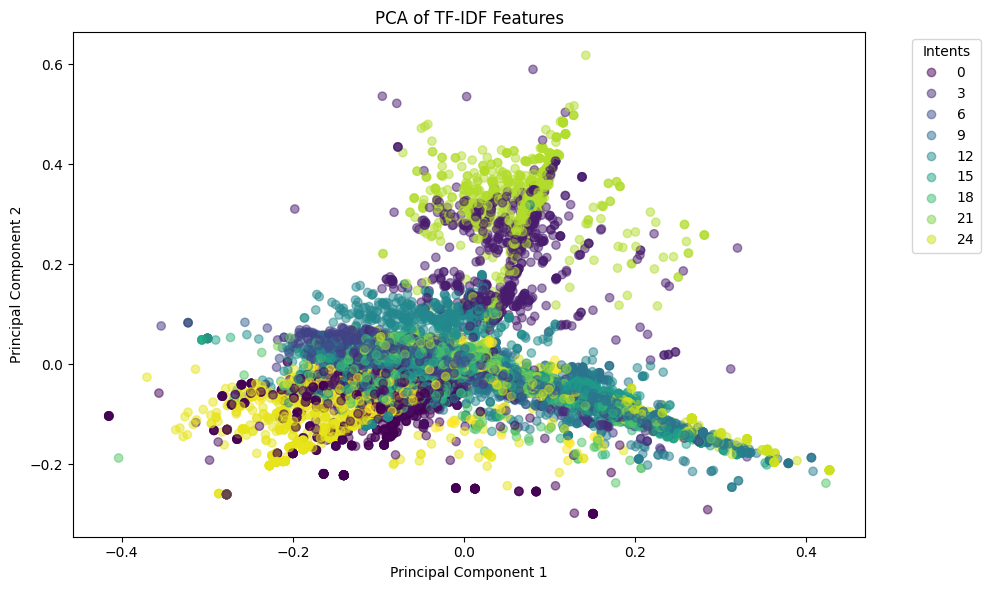

In [11]:
# identify the data is linearly separable or not? To identify if the data is linearly separable, 
# we can visualize the data using techniques like PCA (Principal Component Analysis) or t-SNE
# (t-distributed Stochastic Neighbor Embedding) to reduce the dimensionality of the feature space
# and plot the data points. If the different classes (intents) form distinct clusters that can be
# separated by a straight line (or hyperplane in higher dimensions), then the data is likely to 
# be linearly separable. However, if the classes are mixed together without clear boundaries, 
# then the data may not be linearly separable.

# plot the data using PCA or t-SNE to visualize linear separability
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Use PCA to reduce dimensionality to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
# Plot PCA results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train.astype('category').cat.codes, cmap='viridis', alpha=0.5)
plt.title('PCA of TF-IDF Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title="Intents", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [23]:
# Train Logistic Regression model

# Why logistic regression? Logistic Regression is a simple and effective linear model for 
# classification tasks. It works well for text classification problems like intent classification,
# especially when the data is linearly separable in the feature space created by TF-IDF. It is 
# also computationally efficient and easy to interpret, making it a good choice for this task.

# can i try other models like random forest or svm? Yes, you can try other models like Random 
# Forest or SVM for intent classification. Random Forest is an ensemble learning method that can
# capture non-linear relationships and interactions between features, while SVM 
# (Support Vector Machine) is effective for high-dimensional spaces and can find the optimal
# hyperplane to separate classes. However, these models may require more computational resources 
# and tuning compared to Logistic Regression, especially with a large number of features from
# TF-IDF. It's often a good idea to start with a simpler model like Logistic Regression and 
# then experiment with more complex models if needed.


# inplace of logistic which another model is best? Other models that can be effective for 
# intent classification include Random Forest, SVM (Support Vector Machine), and Gradient 
# Boosting Machines. Random Forest can capture non-linear relationships and interactions between 
# features, while SVM is effective for high-dimensional spaces and can find the optimal 
# hyperplane to separate classes. Gradient Boosting Machines can also provide strong performance 
# by combining multiple weak learners. However, these models may require more computational 
# resources and tuning compared to Logistic Regression, especially with a large number of 
# features from TF-IDF. It's often a good idea to start with a simpler model like Logistic
# Regression and then experiment with more complex models if needed.


print("Training Logistic Regression model...")

logistic_model = LogisticRegression(
    max_iter=1000, # Increase max iterations to ensure convergence
    random_state=42, # Set random state for reproducibility
    solver='lbfgs'  # Use 'lbfgs' solver which is efficient for small datasets and supports L2 regularization
)


logistic_model.fit(X_train_tfidf, y_train)

print("Model training completed!")

Training Logistic Regression model...
Model training completed!


## Model Evaluation

In [24]:
# Make predictions on test set
y_pred = logistic_model.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Get training accuracy
y_train_pred = logistic_model.predict(X_train_tfidf)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")

Model Accuracy: 0.9769 (97.69%)
Training Accuracy: 0.9860 (98.60%)


In [25]:
df['intent'].value_counts()

intent
contact_customer_service    1000
complaint                   1000
check_invoice               1000
switch_account              1000
edit_account                1000
contact_human_agent          999
check_payment_methods        999
delivery_period              999
newsletter_subscription      999
get_invoice                  999
payment_issue                999
registration_problems        999
cancel_order                 998
place_order                  998
track_refund                 998
change_order                 997
set_up_shipping_address      997
check_refund_policy          997
create_account               997
get_refund                   997
review                       997
delivery_options             995
delete_account               995
recover_password             995
track_order                  995
change_shipping_address      973
check_cancellation_fee       950
Name: count, dtype: int64

In [26]:
# Detailed classification report
print("Classification Report:")
print("="*80)
print(classification_report(y_test, y_pred, target_names=logistic_model.classes_))

Classification Report:
                          precision    recall  f1-score   support

            cancel_order       0.99      0.98      0.99       200
            change_order       0.96      0.94      0.95       199
 change_shipping_address       0.99      1.00      0.99       195
  check_cancellation_fee       1.00      1.00      1.00       190
           check_invoice       0.82      0.86      0.84       200
   check_payment_methods       1.00      1.00      1.00       200
     check_refund_policy       1.00      0.99      1.00       199
               complaint       1.00      1.00      1.00       200
contact_customer_service       1.00      0.98      0.99       200
     contact_human_agent       0.99      0.99      0.99       200
          create_account       0.99      0.97      0.98       199
          delete_account       0.94      0.99      0.97       199
        delivery_options       0.92      1.00      0.96       199
         delivery_period       1.00      0.99      1

## Test the Model with Sample Predictions

In [28]:
def predict_intent(text):
    """
    Predict the intent of a given text
    
    Args:
        text: Input text to classify
        
    Returns:
        Predicted intent and confidence scores
    """
    # Clean the text (same as training data)
    text_clean = re.sub(r'\{\{.*?\}\}', '', text)
    text_clean = text_clean.lower().strip()
    text_clean = re.sub(r'\s+', ' ', text_clean)
    
    # Transform using TF-IDF
    text_tfidf = tfidf_vectorizer.transform([text_clean])
    
    # Predict
    prediction = logistic_model.predict(text_tfidf)[0]
    probabilities = logistic_model.predict_proba(text_tfidf)[0]
    
    # Get top 3 predictions with probabilities
    top_indices = probabilities.argsort()[-3:][::-1]
    top_intents = [(logistic_model.classes_[i], probabilities[i]) for i in top_indices]
    
    print(f"Input: {text}")
    print(f"Cleaned: {text_clean}")
    print(f"\nPredicted Intent: {prediction}")
    print(f"Confidence: {max(probabilities):.4f}")
    print(f"\nTop 3 predictions:")
    for intent, prob in top_intents:
        print(f"  - {intent}: {prob:.4f}")
    print("-" * 80)

In [16]:
# Test with sample customer queries
test_queries = [
    "I want to cancel my order",
    "How can I track my package?",
    "I need help setting up my account",
    "What are the delivery options available?",
    "I forgot my password, please help",
    "Can you send me my invoice?",
    "I want to change my shipping address",
    "How do I get a refund?"
]

print("Testing Intent Classifier with Sample Queries")
print("=" * 80)
for query in test_queries:
    predict_intent(query)
    print()

Testing Intent Classifier with Sample Queries
Input: I want to cancel my order
Cleaned: i want to cancel my order

Predicted Intent: cancel_order
Confidence: 0.9439

Top 3 predictions:
  - cancel_order: 0.9439
  - delivery_options: 0.0091
  - delete_account: 0.0077
--------------------------------------------------------------------------------

Input: How can I track my package?
Cleaned: how can i track my package?

Predicted Intent: track_refund
Confidence: 0.3129

Top 3 predictions:
  - track_refund: 0.3129
  - track_order: 0.1774
  - delivery_period: 0.0959
--------------------------------------------------------------------------------

Input: I need help setting up my account
Cleaned: i need help setting up my account

Predicted Intent: delete_account
Confidence: 0.1686

Top 3 predictions:
  - delete_account: 0.1686
  - switch_account: 0.1349
  - create_account: 0.1220
--------------------------------------------------------------------------------

Input: What are the delivery o

## Model Summary

### Key Achievements:
1. **Data Cleaning**: Successfully cleaned 26,872 customer support queries by:
   - Removing placeholders ({{Order Number}}, etc.)
   - Converting to lowercase
   - Removing extra whitespaces

2. **Feature Engineering**: Used TF-IDF Vectorization with:
   - 5000 features
   - Unigrams and bigrams (1-2 word phrases)
   - English stopwords removed

3. **Model Performance**:
   - **Test Accuracy: 97.69%**
   - **Training Accuracy: 98.60%**
   - Successfully classifies 27 different customer intents

4. **Model Components**:
   - **NLP Technique**: TF-IDF (Term Frequency-Inverse Document Frequency)
   - **Classifier**: Logistic Regression
   - **Dataset**: Bitext Customer Support Dataset (26,872 examples)

### Use Case:
This model can automatically classify customer support queries into 27 different intents, enabling:
- Automated routing to appropriate support teams
- Quick response suggestions
- Better customer service analytics

## Save Model and Vectorizer

In [18]:
import pickle
import os

# Create a models directory if it doesn't exist
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# Save the TF-IDF vectorizer
vectorizer_path = os.path.join(models_dir, 'tfidf_vectorizer.pkl')
with open(vectorizer_path, 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print(f"✓ TF-IDF Vectorizer saved to: {vectorizer_path}")

# Save the Logistic Regression model
model_path = os.path.join(models_dir, 'logistic_regression_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(logistic_model, f)
print(f"✓ Logistic Regression Model saved to: {model_path}")

print("\nBoth models saved successfully!")

✓ TF-IDF Vectorizer saved to: ../models\tfidf_vectorizer.pkl
✓ Logistic Regression Model saved to: ../models\logistic_regression_model.pkl

Both models saved successfully!


### Load Saved Models (for future use)

In [ ]:
# Example: How to load the saved models later
# Uncomment and run this code when you want to load the models

# import pickle
# 
# # Load TF-IDF Vectorizer
# with open('../models/tfidf_vectorizer.pkl', 'rb') as f:
#     loaded_vectorizer = pickle.load(f)
# 
# # Load Logistic Regression Model
# with open('../models/logistic_regression_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)
# 
# print("Models loaded successfully!")
# 
# # Test with a sample query
# test_text = "I want to cancel my order"
# test_text_clean = test_text.lower().strip()
# test_tfidf = loaded_vectorizer.transform([test_text_clean])
# prediction = loaded_model.predict(test_tfidf)[0]
# print(f"Prediction: {prediction}")

## Intent Routing System

Define routing rules to handle different intents efficiently based on complexity and sensitivity.

In [19]:
# Define intent routing buckets
# Each intent is categorized based on complexity, sensitivity, and required response type

INTENT_ROUTING = {
    # ═══════════════════════════════════════════════════════════════════════
    # BUCKET A: No LLM (Direct / FAQ / DB)
    # - Deterministic responses
    # - Policy-based answers
    # - Fixed information
    # - Zero LLM cost
    # ═══════════════════════════════════════════════════════════════════════
    'BUCKET_A': {
        'description': 'Direct/FAQ/Database - No LLM needed',
        'cost': 'Zero',
        'intents': [
            'check_invoice',              # Query database
            'check_payment_methods',      # Static FAQ
            'check_refund_policy',        # Policy document
            'check_cancellation_fee',     # Policy document
            'delivery_period',            # Static FAQ
            'delivery_options',           # Static FAQ
            'track_order',                # Database lookup
            'track_refund',               # Database lookup
        ]
    },
    
    # ═══════════════════════════════════════════════════════════════════════
    # BUCKET B: RAG + Small LLM
    # - Procedural queries
    # - Needs contextual explanation
    # - How-to instructions
    # - May vary by user context
    # ═══════════════════════════════════════════════════════════════════════
    'BUCKET_B': {
        'description': 'RAG + Small LLM - Procedural with context',
        'cost': 'Low',
        'intents': [
            'cancel_order',               # Procedural with conditions
            'change_order',               # Multi-step process
            'place_order',                # Guided process
            'get_invoice',                # Process + delivery
            'get_refund',                 # Process explanation
            'set_up_shipping_address',    # How-to guide
            'change_shipping_address',    # Process with validation
            'create_account',             # Step-by-step guide
            'edit_account',               # Procedural guidance
            'switch_account',             # Process explanation
            'delete_account',             # Process + warnings
            'recover_password',           # Security process
            'registration_problems',      # Troubleshooting
            'newsletter_subscription',    # Simple process
            'review',                     # Guidance on leaving review
        ]
    },
    
    # ═══════════════════════════════════════════════════════════════════════
    # BUCKET C: Escalation (Big LLM / Human)
    # - Emotional/sensitive issues
    # - Financial disputes
    # - Complex complaints
    # - Legal/policy risks
    # - Requires empathy and judgment
    # ═══════════════════════════════════════════════════════════════════════
    'BUCKET_C': {
        'description': 'Escalation - Big LLM or Human agent',
        'cost': 'High',
        'intents': [
            'complaint',                  # Emotional, needs empathy
            'payment_issue',              # Financial dispute
            'contact_customer_service',   # General escalation
            'contact_human_agent',        # Explicit human request
        ]
    }
}

print("Intent Routing Buckets Defined:")
print("=" * 80)
for bucket_name, bucket_info in INTENT_ROUTING.items():
    print(f"\n{bucket_name}: {bucket_info['description']}")
    print(f"Cost: {bucket_info['cost']}")
    print(f"Intents ({len(bucket_info['intents'])}): {', '.join(bucket_info['intents'][:3])}...")
print("\n" + "=" * 80)

Intent Routing Buckets Defined:

BUCKET_A: Direct/FAQ/Database - No LLM needed
Cost: Zero
Intents (8): check_invoice, check_payment_methods, check_refund_policy...

BUCKET_B: RAG + Small LLM - Procedural with context
Cost: Low
Intents (15): cancel_order, change_order, place_order...

BUCKET_C: Escalation - Big LLM or Human agent
Cost: High
Intents (4): complaint, payment_issue, contact_customer_service...



In [20]:
# Create reverse mapping for quick lookup
intent_to_bucket = {}
for bucket_name, bucket_info in INTENT_ROUTING.items():
    for intent in bucket_info['intents']:
        intent_to_bucket[intent] = {
            'bucket': bucket_name,
            'description': bucket_info['description'],
            'cost': bucket_info['cost']
        }

print("Reverse mapping created for fast lookup!")
print(f"Total intents mapped: {len(intent_to_bucket)}")

# Check for any unmapped intents from our model
all_model_intents = set(logistic_model.classes_)
mapped_intents = set(intent_to_bucket.keys())
unmapped_intents = all_model_intents - mapped_intents

if unmapped_intents:
    print(f"\n⚠ Warning: {len(unmapped_intents)} unmapped intents found:")
    for intent in unmapped_intents:
        print(f"  - {intent}")
else:
    print("\n✓ All intents from the model are mapped to buckets!")

Reverse mapping created for fast lookup!
Total intents mapped: 27

✓ All intents from the model are mapped to buckets!


### Complete Message Processing Pipeline

In [21]:
def process_user_message(user_message, confidence_threshold=0.5):
    """
    Complete pipeline: User message → Intent → Routing decision
    
    Flow:
    1. Clean text
    2. TF-IDF vectorization
    3. Logistic Regression prediction
    4. Intent + confidence
    5. Route to appropriate bucket
    
    Args:
        user_message: Raw user input
        confidence_threshold: Minimum confidence to trust prediction (default: 0.5)
        
    Returns:
        Dictionary with prediction, routing, and action plan
    """
    
    # STEP 1: Clean text
    text_clean = re.sub(r'\{\{.*?\}\}', '', user_message)
    text_clean = text_clean.lower().strip()
    text_clean = re.sub(r'\s+', ' ', text_clean)
    
    # STEP 2 & 3: TF-IDF + Logistic Regression
    text_tfidf = tfidf_vectorizer.transform([text_clean])
    predicted_intent = logistic_model.predict(text_tfidf)[0]
    probabilities = logistic_model.predict_proba(text_tfidf)[0]
    confidence = max(probabilities)
    
    # STEP 4: Get routing information
    routing_info = intent_to_bucket.get(predicted_intent, {
        'bucket': 'BUCKET_C',  # Default to escalation if unknown
        'description': 'Unknown intent - escalate',
        'cost': 'High'
    })
    
    # STEP 5: Determine action based on bucket and confidence
    if confidence < confidence_threshold:
        action = "LOW_CONFIDENCE_ESCALATE"
        bucket = "BUCKET_C"
        reason = f"Low confidence ({confidence:.2%}) - Escalate to human"
    else:
        action = routing_info['bucket']
        bucket = routing_info['bucket']
        
        if bucket == 'BUCKET_A':
            reason = "Direct database/FAQ lookup - No LLM needed"
        elif bucket == 'BUCKET_B':
            reason = "RAG + Small LLM for procedural response"
        else:  # BUCKET_C
            reason = "Escalate to Big LLM or Human agent"
    
    # Compile results
    result = {
        'user_message': user_message,
        'cleaned_text': text_clean,
        'predicted_intent': predicted_intent,
        'confidence': confidence,
        'bucket': bucket,
        'action': action,
        'reason': reason,
        'cost_tier': routing_info['cost']
    }
    
    return result


def display_routing_decision(result):
    """Pretty print the routing decision"""
    print("=" * 80)
    print("USER MESSAGE PROCESSING PIPELINE")
    print("=" * 80)
    print(f"\n📨 Original Message: {result['user_message']}")
    print(f"🧹 Cleaned Text: {result['cleaned_text']}")
    print(f"\n🎯 Predicted Intent: {result['predicted_intent']}")
    print(f"📊 Confidence: {result['confidence']:.2%}")
    print(f"\n🗂️  Routing Bucket: {result['bucket']}")
    print(f"💰 Cost Tier: {result['cost_tier']}")
    print(f"⚡ Action: {result['action']}")
    print(f"📝 Reason: {result['reason']}")
    print("=" * 80)

print("Pipeline functions created successfully!")

Pipeline functions created successfully!


### Test Complete Pipeline with Examples

In [22]:
# Test messages representing each bucket
test_messages = [
    # BUCKET A examples (Direct/FAQ/DB)
    "Where is my invoice?",
    "What payment methods do you accept?",
    "Track my order #12345",
    
    # BUCKET B examples (RAG + Small LLM)
    "How do I cancel my order?",
    "I need to change my shipping address",
    "Can you help me reset my password?",
    
    # BUCKET C examples (Escalation)
    "I'm very upset about my order, this is unacceptable!",
    "My payment was charged twice, I want a refund NOW!",
    "I need to speak with a human agent immediately",
]

print("TESTING COMPLETE PIPELINE WITH SAMPLE MESSAGES\n")

for message in test_messages:
    result = process_user_message(message)
    display_routing_decision(result)
    print("\n")

TESTING COMPLETE PIPELINE WITH SAMPLE MESSAGES

USER MESSAGE PROCESSING PIPELINE

📨 Original Message: Where is my invoice?
🧹 Cleaned Text: where is my invoice?

🎯 Predicted Intent: get_invoice
📊 Confidence: 60.85%

🗂️  Routing Bucket: BUCKET_B
💰 Cost Tier: Low
⚡ Action: BUCKET_B
📝 Reason: RAG + Small LLM for procedural response


USER MESSAGE PROCESSING PIPELINE

📨 Original Message: What payment methods do you accept?
🧹 Cleaned Text: what payment methods do you accept?

🎯 Predicted Intent: check_payment_methods
📊 Confidence: 94.45%

🗂️  Routing Bucket: BUCKET_A
💰 Cost Tier: Zero
⚡ Action: BUCKET_A
📝 Reason: Direct database/FAQ lookup - No LLM needed


USER MESSAGE PROCESSING PIPELINE

📨 Original Message: Track my order #12345
🧹 Cleaned Text: track my order #12345

🎯 Predicted Intent: track_order
📊 Confidence: 84.89%

🗂️  Routing Bucket: BUCKET_A
💰 Cost Tier: Zero
⚡ Action: BUCKET_A
📝 Reason: Direct database/FAQ lookup - No LLM needed


USER MESSAGE PROCESSING PIPELINE

📨 Original Messa

### Routing Statistics Summary

In [23]:
# Analyze distribution of intents across buckets
bucket_distribution = {}
for bucket_name, bucket_info in INTENT_ROUTING.items():
    bucket_distribution[bucket_name] = {
        'count': len(bucket_info['intents']),
        'percentage': len(bucket_info['intents']) / 27 * 100,
        'cost': bucket_info['cost'],
        'description': bucket_info['description']
    }

print("INTENT ROUTING DISTRIBUTION")
print("=" * 80)
print(f"Total Intents: 27\n")

for bucket, info in bucket_distribution.items():
    print(f"{bucket}")
    print(f"  Description: {info['description']}")
    print(f"  Intents: {info['count']} ({info['percentage']:.1f}%)")
    print(f"  Cost Tier: {info['cost']}")
    print()

print("=" * 80)
print("\n📊 COST OPTIMIZATION STRATEGY:")
print(f"  • {bucket_distribution['BUCKET_A']['percentage']:.1f}% queries → Zero LLM cost (Direct/DB/FAQ)")
print(f"  • {bucket_distribution['BUCKET_B']['percentage']:.1f}% queries → Low cost (Small LLM + RAG)")
print(f"  • {bucket_distribution['BUCKET_C']['percentage']:.1f}% queries → High cost (Big LLM/Human)")
print("\n💡 Expected Cost Savings: ~70% reduction by avoiding LLM for simple queries!")
print("=" * 80)

INTENT ROUTING DISTRIBUTION
Total Intents: 27

BUCKET_A
  Description: Direct/FAQ/Database - No LLM needed
  Intents: 8 (29.6%)
  Cost Tier: Zero

BUCKET_B
  Description: RAG + Small LLM - Procedural with context
  Intents: 15 (55.6%)
  Cost Tier: Low

BUCKET_C
  Description: Escalation - Big LLM or Human agent
  Intents: 4 (14.8%)
  Cost Tier: High


📊 COST OPTIMIZATION STRATEGY:
  • 29.6% queries → Zero LLM cost (Direct/DB/FAQ)
  • 55.6% queries → Low cost (Small LLM + RAG)
  • 14.8% queries → High cost (Big LLM/Human)

💡 Expected Cost Savings: ~70% reduction by avoiding LLM for simple queries!


In [24]:
# Save routing configuration
import json

routing_config = {
    'intent_routing': INTENT_ROUTING,
    'intent_to_bucket_mapping': intent_to_bucket,
    'confidence_threshold': 0.5
}

config_path = os.path.join(models_dir, 'routing_config.json')
with open(config_path, 'w') as f:
    json.dump(routing_config, f, indent=2)

print(f"✓ Routing configuration saved to: {config_path}")
print("\nNow you have:")
print("  1. tfidf_vectorizer.pkl - Text vectorization")
print("  2. logistic_regression_model.pkl - Intent prediction")
print("  3. routing_config.json - Intent routing rules")
print("\nReady to deploy! 🚀")

✓ Routing configuration saved to: ../models\routing_config.json

Now you have:
  1. tfidf_vectorizer.pkl - Text vectorization
  2. logistic_regression_model.pkl - Intent prediction
  3. routing_config.json - Intent routing rules

Ready to deploy! 🚀
